In [2]:
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt

# noinspection PyUnresolvedReferences
from tensorflow.keras.preprocessing.text import Tokenizer
# noinspection PyUnresolvedReferences
from tensorflow.keras.preprocessing.sequence import pad_sequences
from helper import *

In [218]:
data_path = '../data/four_channels.csv'
df = pd.read_csv(data_path)
as_unicode = ("👍", "❤", "🤬", "😢", "😁")
emoji = ("like", "heart", "angry", "sad", "laugh")

df = df[['text'] + list(as_unicode)]
df.columns = ['text'] + list(emoji)
df = df.fillna(0)

df.head()

,text,like,heart,angry,sad,laugh
0,🧡 Кадрові зміни у Кабміні. Новим керівником Мі...,869.0,23.0,14.0,2.0,0.0
1,"💚 Не минуло і місяця після звільнення з ЗСУ, я...",622.0,80.0,277.0,21.0,0.0
2,У Польщі запрацював хаб з ремонту танків Leopa...,2513.0,361.0,10.0,0.0,0.0
3,У Києві затримали колишнього віськкома-втікача...,2639.0,23.0,8.0,4.0,0.0
4,‼️ Через війну ціни в Києві виросли на 247%. \...,154.0,23.0,854.0,74.0,0.0


In [219]:
vocab_words = pd.read_csv('../data/unique_words_optimized.csv')
vocab_words = vocab_words.values.tolist()
vocab_symbols = pd.read_csv('../data/rest.csv')
vocab_symbols = vocab_symbols.values.tolist()
numbers = "0123456789"
special = "’'‘`-"
vocab = vocab_words + vocab_symbols + [[char] for char in numbers] + [[char] for char in special]
vocab_size = len(vocab)
print(vocab_size)
print(f"Vocab: {vocab[:10]}")
print(f"Vocab symbols: {vocab_symbols}")

32267
Vocab: [['на', 67090], ['та', 57276], ['у', 54068], ['в', 52124], ['з', 43385], ['і', 32196], ['не', 26731], ['що', 26134], ['до', 25104], ['за', 24472]]
Vocab symbols: [[' ', 3339998], ['\n', 289517], ['.', 247004], [',', 223882], ['-', 54874], ['️', 50566], ['▪', 27028], [':', 27024], ['"', 26281], ['«', 26043], ['»', 25954], ['–', 22633], ['!', 21852], ['—', 14012], ['/', 11616]]


In [220]:
def filter_string_rows(df):
    return df[df['text'].apply(lambda x: isinstance(x, str))]

def scale_values(df):
    # convert emoji values to int
    df[df.columns[1:]] = df[df.columns[1:]].astype(int)

    # scale values to 0-1 for emoji
    df[df.columns[1:]] = df[df.columns[1:]].apply(lambda row: row / max(row.sum(), 0.1**10), axis=1)

    return df

def add_spaces_between_numbers(text):
    result = ''
    for char in text:
        if char.isdigit():
            result += char + ' '
        else:
            result += char
    return result

def clear_text(df):
    # get allowed characters from vocab by getting all unique characters
    ukr = "абвгґдеєжзиіїйклмнопрстуфхцчшщьюя"
    eng = "abcdefghijklmnopqrstuvwxyz"
    rus = "абвгдеёжзийклмнопрстуфхцчшщъыьэюя"
    numbers = "0123456789"
    special = "’'‘`-"
    all = ukr + eng + rus + numbers + special
    allowed_chars = set()
    for word in vocab_symbols:
        for char in word[0]:
            allowed_chars.add(char)
    for char in all:
        allowed_chars.add(char)
    allowed_chars.add(' ')
    print(f"Allowed chars: {allowed_chars}")

    df['text'] = df['text'].apply(lambda x: ''.join([char for char in x.lower() if char in allowed_chars]) if isinstance(x, str) else x)
    return df

data = filter_string_rows(df)
data = scale_values(data)
data['text'] = data['text'].apply(add_spaces_between_numbers)
data = clear_text(data)
data.head()

Allowed chars: {'q', 'у', '‘', 'а', '8', 'в', 'д', 'd', 'o', 'ф', 'v', 'з', 'с', 'c', 'ё', 'є', 'п', ',', 'я', 'щ', '5', 'w', 'к', 'a', '️', 'i', '.', '9', '—', '"', 'g', 'u', '3', '4', '«', 't', 'ц', '–', 'e', ':', '1', 'и', 'ґ', 'р', 'л', 'b', '!', 'k', 'ь', 'ї', 'э', '»', 'і', 'p', '7', '0', '2', ' ', 'ъ', 'ч', '\n', 'h', 'ы', 'н', '6', 'ю', 'r', 'x', '`', 'y', 'х', 'б', '▪', 'j', 'м', '/', '’', '-', 'm', 'z', 'е', 'ш', 'l', 'й', 'г', "'", 'n', 's', 'о', 'т', 'f', 'ж'}


,text,like,heart,angry,sad,laugh
0,кадрові зміни у кабміні. новим керівником мін...,0.957048,0.025330,0.015419,0.002203,0.0
1,"не минуло і місяця після звільнення з зсу, як...",0.622000,0.080000,0.277000,0.021000,0.0
2,у польщі запрацював хаб з ремонту танків leopa...,0.871359,0.125173,0.003467,0.000000,0.0
3,у києві затримали колишнього віськкома-втікача...,0.986911,0.008601,0.002992,0.001496,0.0
4,️ через війну ціни в києві виросли на 2 4 7 . ...,0.139367,0.020814,0.772851,0.066968,0.0


In [221]:
def articles_and_labels(df):
    return df['text'].tolist(), df[df.columns[1:]].values.tolist()

def argmax_labels(labels):
    # from [0.1, 0.2, 0.7] to [0, 0, 1]
    one_hot_labels = np.eye(len(labels[0]))
    return [one_hot_labels[np.argmax(label)] for label in labels]

articles, labels = articles_and_labels(data)
# labels = argmax_labels(labels)
print(f"Articles: {len(articles)}, Labels: {len(labels)}")
print(f"Example: {articles[0]}, {labels[0]}")

Articles: 75469, Labels: 75469
Example:  кадрові зміни у кабміні. новим керівником мінкульту може стати антон дробович, очільник інституту національної пам’яті або олеся островська-люта, директорка «мистецького арсеналу».

«дробович — це буде міністр-воїн, який вміє формувати вірні наративи та має зважено доносити історичний багаж. проте до кандидатури островської-лютої більш схильні на банковій», — кажуть наші джерела у парламенті. 

як нам стало відомо, крісло хитається ще й під міністром молоді і спорту вадимом гутцайтом. 

times of ukraine , [0.9570484581497798, 0.025330396475770924, 0.015418502202643172, 0.0022026431718061676, 0.0]


In [222]:
(train_articles, train_labels), (test_articles, test_labels) = split_data(articles, labels, 0.8)
print(f"Train articles: {len(train_articles)}, Train labels: {len(train_labels)}")

Train articles: 60375, Train labels: 60375


In [223]:
max_length = 100
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"

In [224]:
tokenizer = Tokenizer(num_words=vocab_size + 1, oov_token=oov_tok)
word_index = {v[0]: i+1 for i, v in enumerate(vocab)}
word_index[oov_tok] = 0
tokenizer.word_index = word_index

print(f"Word index: {len(word_index)}")
print(f"Word index: {list(word_index.items())[:10]}")

Word index: 32267
Word index: [('на', 1), ('та', 2), ('у', 3), ('в', 4), ('з', 5), ('і', 6), ('не', 7), ('що', 8), ('до', 9), ('за', 10)]


In [225]:
import os

model_name = 'model_1'
# chech if path exists
if not os.path.exists(f'../models/{model_name}'):
    os.makedirs(f'../models/{model_name}')
with open(f'../models/{model_name}/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [226]:
def words_per_article(articles):
    # calculate words in each article
    words_in_articles = [len(article.split(" ")) for article in articles]

    # calculate min, max, mean
    min_words = min(words_in_articles)
    max_words = max(words_in_articles)
    mean_words = sum(words_in_articles) / len(articles)

    return min_words, max_words, mean_words

min_words, max_words, mean_words = words_per_article(train_articles)
print(f"Min Words: {min_words}, Max Words: {max_words}, Mean Words: {mean_words}")

Min Words: 2, Max Words: 2903, Mean Words: 51.28664182194617


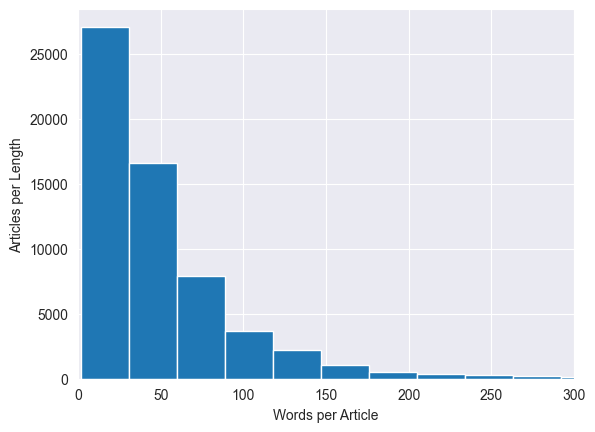

In [227]:
# plot distribution of words per article
words_per_article = [len(article.split(" ")) for article in train_articles]
plt.hist(words_per_article, bins=100)
plt.xlabel("Words per Article")
plt.ylabel("Articles per Length")
plt.xlim(0, 300)
plt.show()

In [228]:
train_padded = seq_pad_and_trunc(train_articles, tokenizer, padding_type, trunc_type, max_length)
test_padded = seq_pad_and_trunc(test_articles, tokenizer, padding_type, trunc_type, max_length)

print(f"Train Padded: {train_padded.shape}, Validation Padded: {test_padded.shape}")

Train Padded: (60375, 100), Validation Padded: (15094, 100)


In [229]:
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

In [230]:
# print some examples
for i in range(5):
    print(f"Article: {train_articles[i]}")
    print(f"Article Padded: {train_padded[i]}")
    words = list(tokenizer.word_index.items())
    padded_to_article = [words[i - 1] for i in train_padded[i] if i != 0]
    print(f"Padded to Article: {padded_to_article}")
    print(f"Answer: {train_labels[i]}")
    print()

Article: без імені, а просто «угольок»

за таким позивним у лавах 3 5 -ої окремої бригади морської піхоти можна знайти снайперку, яка з 2 0 1 7  року боронить україну

дівчина пішла до армії, аби молодший брат пишався нею. так і сталося. у січні вона планувала зробити перерву, проте війна повернула її до служби. 

пишаємося сміливістю наших українських воїнів і наших дівчат військових! ви - приклад сили! завдяки вам віримо у скорішу перемогу над ворогом!

герої 
Article Padded: [   83   978    17   294     0    10   764  3122     3  3595 32256 32258
  6353   916   316  1913  1364   141  1205     0   109     5 32255 32253
 32254 32260    77     0    70  3200  5305     9   242   330  9919  6697
     0  2400    55     6  1183     3  3507   147 10015   538     0   387
   365  2817    97     9   399  1965 16837    92    85   787     6    92
  7032   111   161  3500   106   396   373  1201     3     0   666   125
     0   701     0     0     0     0     0     0     0     0     0     0
     0

In [231]:
import keras.layers as L

def create_model(vocab_size, embedding_dim, max_length):
    input = L.Input(shape=(max_length,))
    x = L.Embedding(vocab_size, embedding_dim)(input)
    x = L.Flatten()(x)
    x = L.Dense(32, activation="relu")(x)
    x = L.Dropout(0.2)(x)
    x = L.Dense(5, activation="softmax")(x)
    model = tf.keras.Model(inputs=input, outputs=x)
    return model

model = create_model(vocab_size, 16, max_length)

# loss = tf.keras.losses.KLDivergence()
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
metrics = ["accuracy"]
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

model.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 100)]             0         
                                                                 
 embedding_13 (Embedding)    (None, 100, 16)           516272    
                                                                 
 flatten_13 (Flatten)        (None, 1600)              0         
                                                                 
 dense_27 (Dense)            (None, 32)                51232     
                                                                 
 dropout_13 (Dropout)        (None, 32)                0         
                                                                 
 dense_28 (Dense)            (None, 5)                 165       
                                                                 
Total params: 567,669
Trainable params: 567,669
Non-traina

In [232]:
epochs = 10
batch_size = 128
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=f"../models/{model_name}_checkpoint.h5",
    save_weights_only=False,
    monitor="val_accuracy",
    mode="max",
    save_best_only=True
)
history = model.fit(train_padded, train_labels, epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(test_padded, test_labels),
                    callbacks=[checkpoint_callback])

Epoch 1/10
472/472 [==============================] - 3s 6ms/step - loss: 1.5144 - accuracy: 0.3466 - val_loss: 1.4766 - val_accuracy: 0.3510
Epoch 2/10
472/472 [==============================] - 3s 6ms/step - loss: 1.4516 - accuracy: 0.3855 - val_loss: 1.4056 - val_accuracy: 0.4067
Epoch 3/10
472/472 [==============================] - 3s 5ms/step - loss: 1.3617 - accuracy: 0.4262 - val_loss: 1.2963 - val_accuracy: 0.4676
Epoch 4/10
472/472 [==============================] - 3s 6ms/step - loss: 1.2415 - accuracy: 0.4956 - val_loss: 1.1833 - val_accuracy: 0.5233
Epoch 5/10
472/472 [==============================] - 3s 6ms/step - loss: 1.1492 - accuracy: 0.5391 - val_loss: 1.1190 - val_accuracy: 0.5510
Epoch 6/10
472/472 [==============================] - 3s 6ms/step - loss: 1.0875 - accuracy: 0.5698 - val_loss: 1.0807 - val_accuracy: 0.5689
Epoch 7/10
472/472 [==============================] - 3s 6ms/step - loss: 1.0427 - accuracy: 0.5963 - val_loss: 1.0544 - val_accuracy: 0.5794
Epoch 

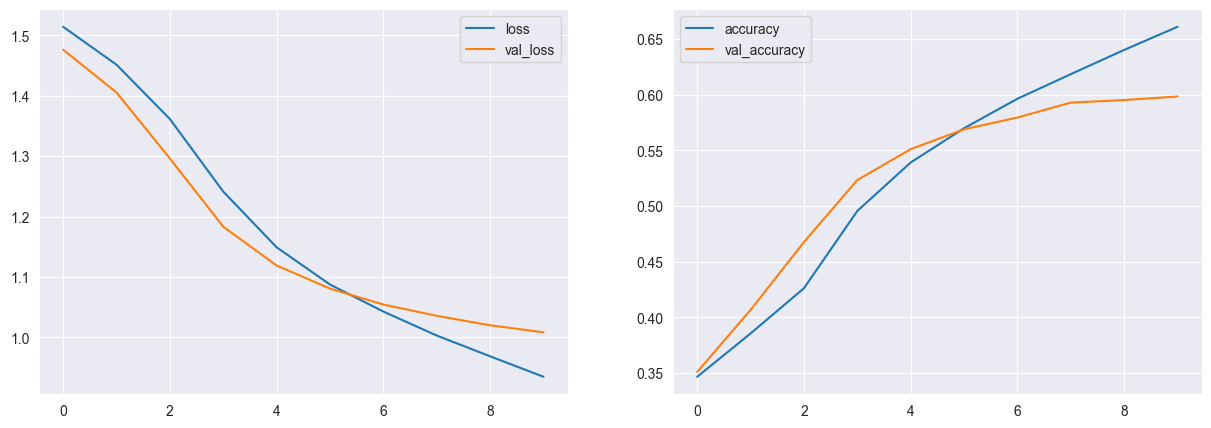

In [233]:
def plot_history(history):
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.legend()
    plt.show()

    plt.plot(history.history["accuracy"], label="accuracy")
    plt.plot(history.history["val_accuracy"], label="val_accuracy")
    plt.legend()
    plt.show()

def plot_history_as_subplots(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.plot(history.history["loss"], label="loss")
    ax1.plot(history.history["val_loss"], label="val_loss")
    ax1.legend()
    ax2.plot(history.history["accuracy"], label="accuracy")
    ax2.plot(history.history["val_accuracy"], label="val_accuracy")
    ax2.legend()
    plt.show()

plot_history_as_subplots(history)

In [234]:
# load best model
model = tf.keras.models.load_model(f"../models/{model_name}_checkpoint.h5")

# evaluate on test data
model.evaluate(test_padded, test_labels)

472/472 [==============================] - 1s 846us/step - loss: 1.0083 - accuracy: 0.5983


[1.0083320140838623, 0.5983172059059143]

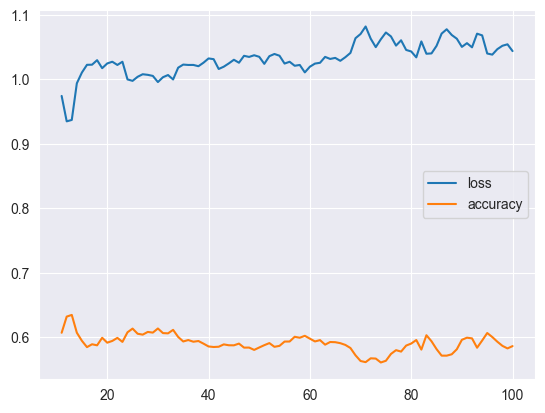

In [236]:
splited = {}
for i in range(len(test_labels)):
    varticle = test_articles[i]
    vanswer = test_labels[i]

    length = len(varticle.split(" "))
    if length > max_length:
        continue
    if length not in splited:
        splited[length] = []

    splited[length].append((varticle, vanswer))

results = {}
# sort splited by length
splited = dict(sorted(splited.items(), key=lambda item: item[0]))
for key in splited:
    varticles = [row[0] for row in splited[key]]
    vanswers = [row[1] for row in splited[key]]
    varticles_padded = seq_pad_and_trunc(varticles, tokenizer, padding_type, trunc_type, max_length)
    vanswers = np.array(vanswers)
    # print(f"Length: {key}, Articles: {len(varticles)}, Answers: {len(vanswers)}")
    pred = model.evaluate(varticles_padded, vanswers, verbose=0)
    # get mean of loss and accuracy
    results[key] = (pred[0], pred[1])

# make df from results
results_df = pd.DataFrame(results.items(), columns=["Length", "Results"])
# use rolling mean to smooth the data
results_df["Loss"] = results_df["Results"].apply(lambda x: x[0]).rolling(10).mean()
results_df["Accuracy"] = results_df["Results"].apply(lambda x: x[1]).rolling(10).mean()
results_df = results_df.drop(columns=["Results"])

# plot results
plt.plot(results_df["Length"], results_df["Loss"], label="loss")
plt.plot(results_df["Length"], results_df["Accuracy"], label="accuracy")
plt.legend()
plt.show()

Allowed chars: {'q', 'у', '‘', 'а', '8', 'в', 'д', 'd', 'o', 'ф', 'v', 'з', 'с', 'c', 'ё', 'є', 'п', ',', 'я', 'щ', '5', 'w', 'к', 'a', '️', 'i', '.', '9', '—', '"', 'g', 'u', '3', '4', '«', 't', 'ц', '–', 'e', ':', '1', 'и', 'ґ', 'р', 'л', 'b', '!', 'k', 'ь', 'ї', 'э', '»', 'і', 'p', '7', '0', '2', ' ', 'ъ', 'ч', '\n', 'h', 'ы', 'н', '6', 'ю', 'r', 'x', '`', 'y', 'х', 'б', '▪', 'j', 'м', '/', '’', '-', 'm', 'z', 'е', 'ш', 'l', 'й', 'г', "'", 'n', 's', 'о', 'т', 'f', 'ж'}
1/1 [==============================] - 0s 17ms/step
Article: Німецький Бундестаг не схвалив передачу Україні ракет Taurus

Більшість депутатів не підтримали проект резолюції опозиційної партії ХДС із закликом передати Україні далекобійні ракети Taurus.

Законопроект було відхилено в результаті поіменного голосування 485 голосами проти, 178 голосами «за», троє депутатів утрималися.
Unfamiliar Words: 0


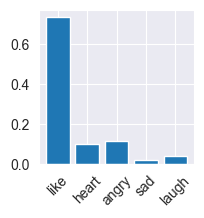

In [250]:
o_article = """Німецький Бундестаг не схвалив передачу Україні ракет Taurus

Більшість депутатів не підтримали проект резолюції опозиційної партії ХДС із закликом передати Україні далекобійні ракети Taurus.

Законопроект було відхилено в результаті поіменного голосування 485 голосами проти, 178 голосами «за», троє депутатів утрималися."""

article = add_spaces_between_numbers(o_article)
article = clear_text(pd.DataFrame([article], columns=["text"]))["text"][0]
article = add_spaces_between_numbers(article)
article = article.lower()
article_padded = seq_pad_and_trunc([article], tokenizer, padding_type, trunc_type, max_length)
article_padded = np.array(article_padded)

predictions = model.predict(article_padded)

count = sum([1 for num in article_padded[0] if num == 1])
print(f"Article: {o_article}")
print(f"Unfamiliar Words: {count}")

plt.bar(df.columns[1:], predictions[0])
plt.gcf().set_size_inches(2, 2)
plt.xticks(rotation=45)
plt.show()